<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/5_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. Hyperparameter tuning

Want the best performance of your ML model without unnecessary complexity? This workshop will explore **hyperparameter tuning** techniques to optimise your model, improve accuracy, and reduce resource usage. Think of your ML model as a tool—like a hammer. If you're new to a task, you might use an adequate tool, but your technique may not be optimal. How you hold the hammer, its size, and the impact angle all act as "hyperparameters". Tuning (adjusting) these paramaters helps you get better results across different situations (like hammering nails into softwood vs. hardwood). We aim to find the best configuration that improves performance while keeping things efficient.

<figure>
    <img src="images/hyper_tuning_chatgpt.png" width="400">
    <figcaption>Figure 1: Hyperparameter tuning visualization - ChatGPT</figcaption>
</figure>


## 5.1 Problem definition

To make things easier, we will use a dataset that we have used before for other workshops. The task is to predict the water level at the Hagestein station in The Netherlands using a selection of five meteorological and hydrological variables: the discharge of the Rhine (QRHINE) and Meuse (QMEUSE) at the Dutch border, the water level of the North Sea (WLHv), precipitation (RH) and evaporation (EV24).  for more details check [Hauswirth et al. (2021)](https://doi.org/10.1016/j.advwatres.2021.104017).

In the code below we import the usual libraries, load the data, select the abovementioned variables and split it between train and test sets as we have already learnt to do.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data_url = "https://raw.githubusercontent.com/Jignesh1594/CodeGeoworkshop_02_understanding_RF/master/data.csv"
data = pd.read_csv(data_url, delimiter=",", on_bad_lines='skip')

# Select input and output variables
input_data = data[['WLHv', 'RH', 'EV24', 'QMeuse', 'QRhine']]
output_data = data['value']

# Chronological Train-Test Split
train_size = int(0.80 * len(input_data))  # 80% for training/validation, 20% for testing

X_trainval, X_test = input_data.iloc[:train_size], input_data.iloc[train_size:]
y_trainval, y_test = output_data.iloc[:train_size], output_data.iloc[train_size:]

## 5.2 The validation split

We have already split the dataset into training and test sets, but to properly tune the hyperparameters we need to introduce an additional one, the **validation set**. This allows us to optimise the hyperparameters on the training and validation sets, while reserving the test set for unbiased final evaluation.

There are many ways to **split your dataset**, but for time-series data we want to ensure that the test set represents future data, as that will not be available when using it for forecasting. Therefore, we cannot split the dataset randomly. For this example we are going to use **60% of the dataset for training**, **20% for validation**, **and 20% for testing**. There is not perfect way to define the proportions, but this might be influenced by the amount of data you have.

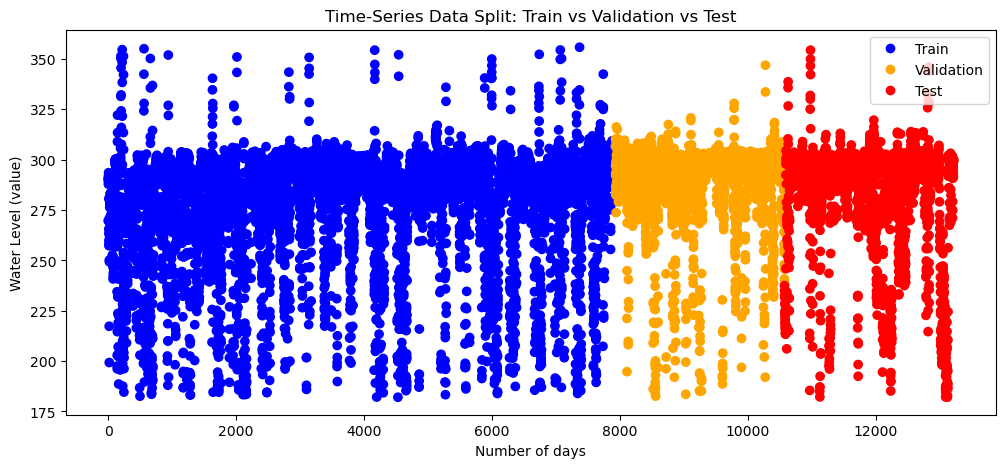

In [25]:

# Further Split Training Data into Train and Validation Sets
train_size = int(0.75 * len(X_trainval))  # 75% for training, 25% for validation. In total 60% training / 20% validation / 20% testing

X_train, X_val = X_trainval.iloc[:train_size], X_trainval.iloc[train_size:]
y_train, y_val = y_trainval.iloc[:train_size], y_trainval.iloc[train_size:]

# Create a new column to label the dataset
data['Dataset'] = 'Test'  # Default label

data.iloc[:len(X_train), data.columns.get_loc('Dataset')] = 'Train'
data.iloc[len(X_train):len(X_train) + len(X_val), data.columns.get_loc('Dataset')] = 'Validation'

# Plot the dataset labeling
plt.figure(figsize=(12, 5))
plt.scatter(data.index, data['value'], c=data['Dataset'].map({'Train': 'blue', 'Validation': 'orange', 'Test': 'red'}), label="Data Points")
plt.xlabel("Number of days")
plt.ylabel("Water Level (value)")
plt.title("Time-Series Data Split: Train vs Validation vs Test")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Train'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='Validation'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Test'),
])

plt.show()


## 5.2 Tuning a single hyperparameter

Our "hammer" for this task will be .... **Random Forest!** Depending on the implementation of this method, you can tune different hyperparameters. For example, for the [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.RandomForestRegressor.html) you can tune, among others, the number of decision trees (**n_estimators**), the maximum depth of the trees(**max_depth**), or the minimum number of samples required to split an internal node (**min_samples_split**). Deciding the best hyperparameter to tune is already an important decision, but for now, we will select only one: **min_samples_split**. As you remember from previous workshops, **Random Forest** is a collection of many decision trees, so **min_samples_split** hyperparameter is inherited from the [decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) model itself.

Below, we visually illustrate the difference between using a different **min_samples_split** value using a the first 200 points of our dataset to train a single decision tree. In short, with this hyperparameter, you decide when a tree stops branching. If this does not make sense to you, check out our [Workshop about Random Forest](https://github.com/oriol-pomarol/codegeo_workshops/blob/main/1_understanding_random_forest.ipynb)! In general, you will have more branches ('decision nodes') if the **min_samples_split** value is smaller. This can significantly affect the generalisation ability of your model (underfitting/overfitting), but this is a topic for a future workshop. This also has implications for the resources you need for the model. More "decision nodes" require more computations.

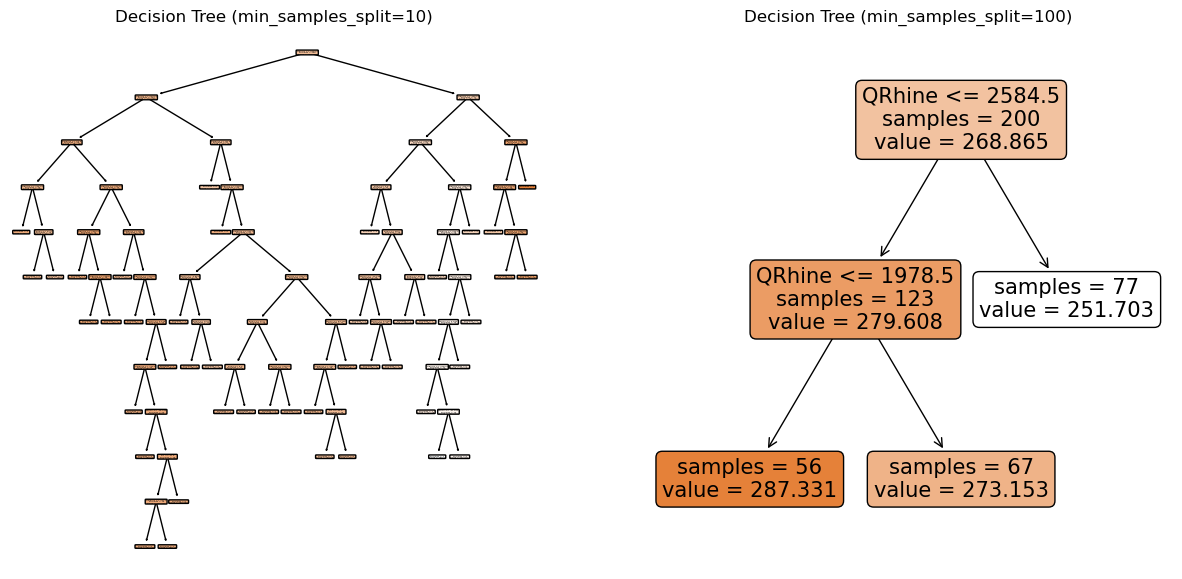

In [26]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree


# Train a Decision Tree with min_samples_split = 10
tree1 = DecisionTreeRegressor(min_samples_split=10, random_state=10)
tree1.fit(X_train[:200], y_train[:200])

# Train Decision Tree with min_samples_split = 50
tree2 = DecisionTreeRegressor(min_samples_split=100, random_state=10)
tree2.fit(X_train[:200], y_train[:200])

# Plot the trees
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

plot_tree(tree1, filled=True, ax=axes[0], rounded=True,
          feature_names=X_train.columns, impurity=False)
axes[0].set_title("Decision Tree (min_samples_split=10)")

plot_tree(tree2, filled=True, ax=axes[1], rounded=True, 
          feature_names=X_train.columns, impurity=False)
axes[1].set_title("Decision Tree (min_samples_split=100)")

plt.show()


As you can see from the right subplot, the nodes that have less than 100 samples are not split anymore, creating a much smaller tree.

### Tuning the min_samples_split hyperparameter

Now that we know what the hyperparameter we selected (**min_samples_split**) is doing, we can start finding a good configuration. The most simple (yet inefficient) approach is to map the effect of changing the number of this hyperparameter. We train the Random Forest model using the **train set** and evaluate the performance using the **validation set**. Here, we check the **mean square error** between the expected values of the **validation set** and the predictions. This will be our **criteria** to decide the better or worse result. Below, we select values between 2 and 250. Do you know why we selected that range (**24 hyperparameter configurations**)? Does that make sense to you?

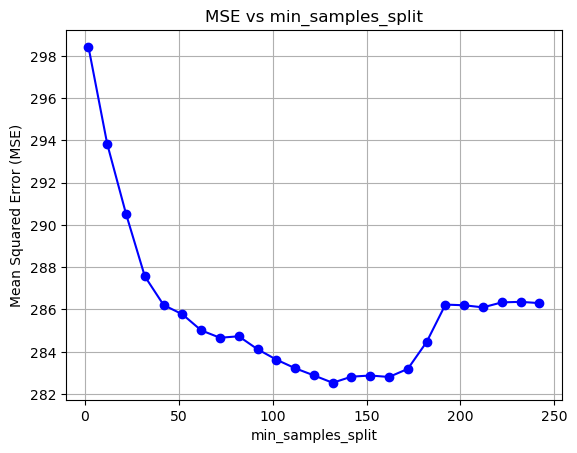

In [27]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# List to store MSE for each value of min_samples_split
mse_values = []
min_samples_split_values = range(2, 250, 10)
hyperparameter_configurations = []  # To store the hyperparameter configurations

# For loop to train models with different min_samples_split values
for min_samples in min_samples_split_values:
    # Create and train the model
    model = RandomForestRegressor(n_estimators=100, min_samples_split=min_samples, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions and calculate MSE
    y_pred = model.predict(X_val)
    mse = metrics.mean_squared_error(y_val, y_pred)
    
    # Store the MSE value
    mse_values.append(mse)
    hyperparameter_configurations.append({'min_samples_split': min_samples, 'mse': mse})

# Plotting the MSE for each min_samples_split value
plt.plot(min_samples_split_values, mse_values, marker='o', linestyle='-', color='b')
plt.title("MSE vs min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()


According to the results, the mean squared error (MSE) is low when **min_samples_split** ranges from 122 to 162. Notice that the default value according to *sklearn* (min_samples_split=2) actually results in the highest MSE for the validation set. Let's see the top performing values using a pandas dataframe.

In [28]:
# MSE per hyperparameter configuration
hyperparameter_df = pd.DataFrame(hyperparameter_configurations)

# Sort the table by MSE
hyperparameter_df = hyperparameter_df.sort_values(by='mse')

# Retrieve the best hyperparameter value
best_hyperparameter = int(hyperparameter_df.iloc[0]['min_samples_split'])

# Display the table
print("Hyperparameter configurations and their corresponding MSE:")
hyperparameter_df.head()

Hyperparameter configurations and their corresponding MSE:


,min_samples_split,mse
13,132,282.533404
16,162,282.808143
14,142,282.822519
15,152,282.877268
12,122,282.882249


Above, you can see the top 5 configurations. Differences are small, but the winner is min_samples_split=132. Now we are ready to train our tuned model!

### Model validation

We now know that 132 is a good value for **min_samples_split**, but can we trust the MSE that we got from tuning? Let's train our models again and check the performance on both validation and the test sets.

In [ ]:
# Train the Random Forest model with the best hyperparameter
best_model = RandomForestRegressor(n_estimators=100, min_samples_split=best_hyperparameter, random_state=42)
best_model.fit(X_train, y_train)

# Train the Random Forest model with the default hyperparameter
default_model = RandomForestRegressor(n_estimators=100, random_state=42)
default_model.fit(X_train, y_train)

# Evaluate the model on the validation set 
y_val_pred_best = best_model.predict(X_val)
val_mse_best = metrics.mean_squared_error(y_val, y_val_pred_best)

y_val_pred_default = default_model.predict(X_val)
val_mse_default = metrics.mean_squared_error(y_val, y_val_pred_default)

# Evaluate the model on the test set
y_test_pred_best = best_model.predict(X_test)
test_mse_best = metrics.mean_squared_error(y_test, y_test_pred_best)

y_test_pred_default = default_model.predict(X_test)
test_mse_default = metrics.mean_squared_error(y_test, y_test_pred_default)

# Display the results as a dataframe
pd.DataFrame({
    'Model': ['RF (Tuned)', 'Random Forest (Default)'],
    'Validation MSE': [val_mse_best, val_mse_default],
    'Test MSE': [test_mse_best, test_mse_default]
})

,Model,Validation MSE,Test MSE
0,RF (Tuned),282.533404,355.344254
1,Random Forest (Default),298.421835,361.199908


For the tuned RF, the Mean Squared Error is very low for the test set. However, this is misleading because we chose that hyperparameter based on the **validation set** itself. Therefore, the tuned model is going to be very good at making predictions for that set. That's why, to evaluate the model in a fair way, we need to do it on unseen data, the **test set**. There, we see that the tuned model is still better, but not by such margin: from 5% to a 2% improvement in the validation and test sets respectively.

### Re-training the models

We can re-train our model using the train and validation set together using that hyperparameter. It is okay to use the validation set *now* for training, as we do not need to validate any more hyperparameters, so we can unlock this data for improving our model results.

In [30]:
# Train the tuned model again using the training + validation data
best_model = RandomForestRegressor(min_samples_split=best_hyperparameter, random_state=42)
best_model.fit(X_trainval, y_trainval)

# Train the default model again using the training + validation data
default_model = RandomForestRegressor(random_state=42)
default_model.fit(X_trainval, y_trainval)

RandomForestRegressor(random_state=42)

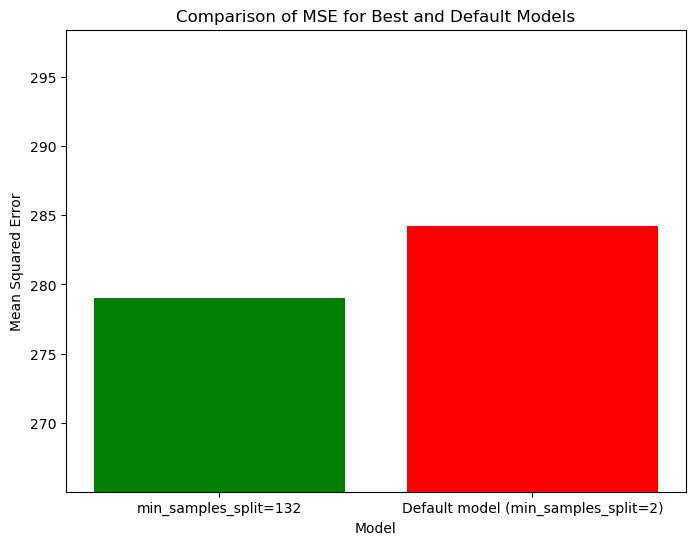

In [33]:
# Predict on the test set
y_test_pred_best = best_model.predict(X_test)
y_test_pred_default = default_model.predict(X_test)

# Get the mse for the best and default models
mse_best = metrics.mean_squared_error(y_test, y_test_pred_best)
mse_default = metrics.mean_squared_error(y_test, y_test_pred_default)

test_mse = [mse_best, mse_default]
model_names = ["min_samples_split=132", 'Default model (min_samples_split=2)']

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(model_names, test_mse, color=['green', 'red'])

# Adjust the y-axis limits to emphasize the differences
min_mse = min(test_mse)
max_mse = max(test_mse)
plt.ylim(min_mse * 0.95, max_mse * 1.05)  # Adjust limits to zoom in

# Add labels and title
plt.title('Comparison of MSE for Best and Default Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')

# Show the plot
plt.show()

We can get better results than the default configuration using the hyperparameter we found during hyperparameter tuning. So, we improved our model for our prediction by simply modifying one hyperparameter. But how does that look in the final prediction? Below, you can see the absolute difference between the expected value and the two predictions (model using best hyperparameter vs Default model)

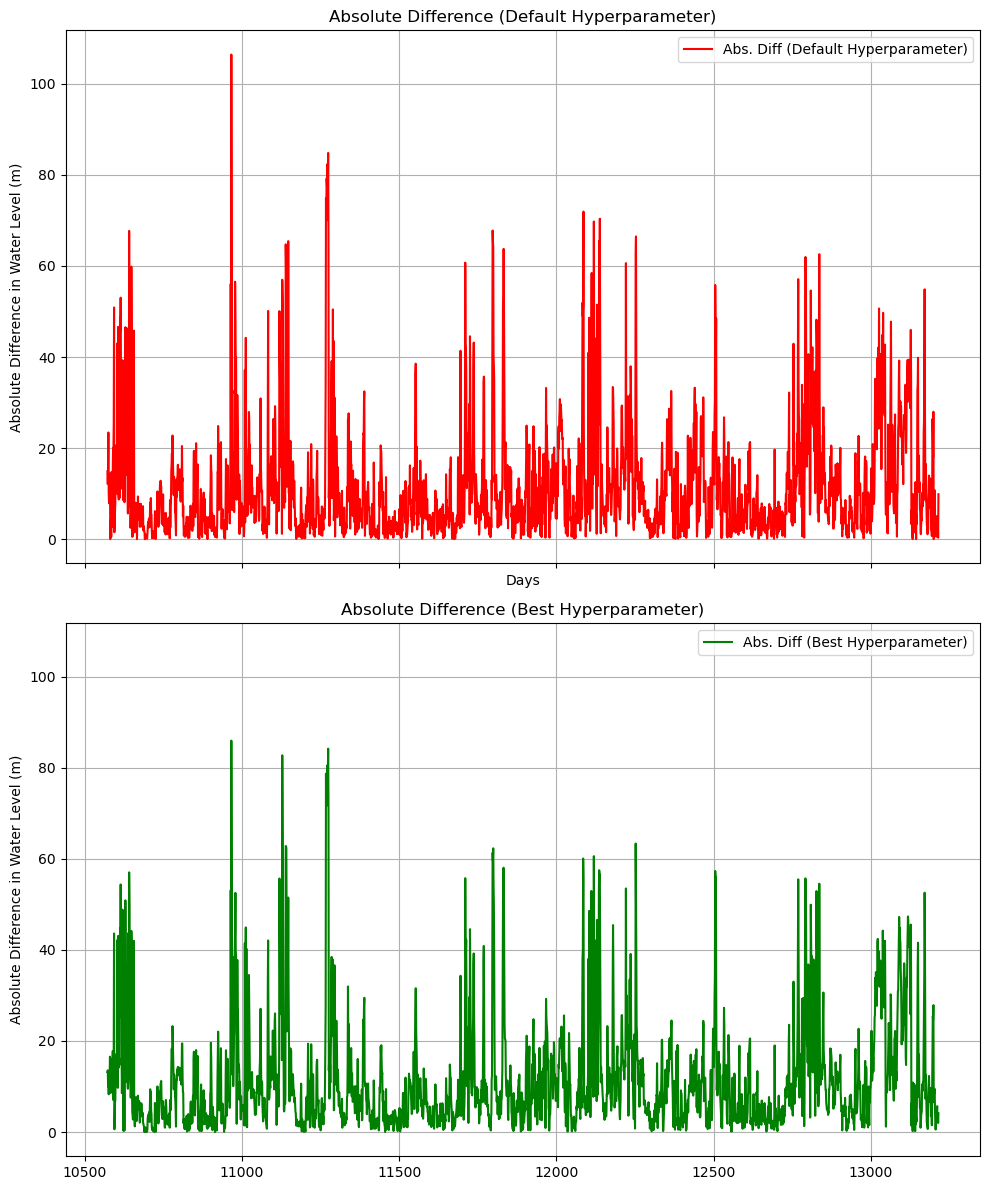

In [34]:
import matplotlib.pyplot as plt

# Calculate absolute differences
abs_diff_best = abs(y_test - y_test_pred_best)
abs_diff_default = abs(y_test - y_test_pred_default)

# Create subplots with shared x-axis
fig, ax = plt.subplots(2, 1, figsize=(10, 12), sharex=True, sharey=True)

# Plot Absolute Difference for Default Hyperparameter
ax[0].plot(y_test.index, abs_diff_default, label="Abs. Diff (Default Hyperparameter)", color='red')
ax[0].set_title("Absolute Difference (Default Hyperparameter)")
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Absolute Difference in Water Level (m)")
ax[0].legend()
ax[0].grid(True)

# Plot Absolute Difference for Best Hyperparameter
ax[1].plot(y_test.index, abs_diff_best, label="Abs. Diff (Best Hyperparameter)", color='green')
ax[1].set_title("Absolute Difference (Best Hyperparameter)")
ax[1].set_ylabel("Absolute Difference in Water Level (m)")
ax[0].set_xlabel("Days")
ax[1].legend()
ax[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## 5.3 Advanced hyperparameter tuning

Most ML models have multiple hyperparameters that you need to tweak. However, we cannot simply repeat the process above with each of them separately, since the optimal value of a hyperparameter will also depend on the value of the others. Hence, we need to tune all hyperparameters at once to find the optimal combination. There are several strategies to do that, each with its own adavatanages:

1. **GridSearchCV** - This method exhaustively searches through a predefined set of hyperpameters. It evaluates every possible combination to find the optimal set. It can be computationally expensive, especially when dealing with a large hyperparameter space.
2. **RandomSearhCV** - This method compares random combinations from a predefined set of hyperparameters. This may not cover every combination, it often finds a good solution much faster that **GridSearchCV**.
3. Specialized packages -
      1. **Optuna** - It is automatic hyperparameter optimzation software framework. Instead of exhaustively searching all possible combinations, it focuses on exploring areas where hyperparameters are likely to yield better results (**Sampling Strategy**). Additionally, it includes early-stopping methods to discard poorly performing hyperparameter combinations based on intermediate results, saving time and computation (**Pruning Strategy**).

Let's compare the three of them for the same model that we used before.

### Grid search

The *sklearn* package offers a nice function that allows us to perform a grid search called `GridSearchCV`. We only need to provide it with an estimator (that is, our ML model), and a parameter grid which contains the names of the hyperparameters that we want to tune and the values that we want to explore in a dictionary object. Let's first create this dictionary with the parameter grid.

In [ ]:
# Define the hyperparameter search space.
parameters = {
              'max_features': [1, 2, 3, 4, 5], # how many features to consider when splitting
              'min_samples_split' : [25, 50, 75, 100, 125, 150, 175, 200], # minimum sample size to split a node
              }

Great, now that we have defined which values of our hyperparameters we want to test, we can define our random forest model and call the grid search from *sklearn*. Remember to `.fit` your grid search object on the training data to actually perform the grid search. As the name suggests, this automatically splits the data between training and validation using a **cross-validation** split (CV), so we don't need to do it ourselves - this is why we use the `trainval` set for tuning. By default it makes five splits, then iteratively trains on four of them and validates on the remaining one.

We also store the time it takes to run each parameter tuning method for later comparison using the `time` library to compute the difference between the time at the end compared to the beginning of the search. Before that, we check the number of cores available and use them to speed up the process.

In [ ]:
import os

# Count the number of cpu cores
n_cores = os.cpu_count()
n_cores

In [ ]:
from sklearn.model_selection import GridSearchCV
import time

# Start the timer
start_time = time.time()

# Create the model and perform a grid search
rf_model = RandomForestRegressor(random_state=10)
grid_search = GridSearchCV(estimator=rf_model, param_grid=parameters,
                           scoring='neg_mean_squared_error', verbose=2,
                           n_jobs=n_cores)
grid_search.fit(X_trainval, y_trainval.values.ravel())

# End the timer and store the duration
duration_grid = time.time() - start_time

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Once it has been run, we can easily access the best-performing model, its corresponding hyperparameters and its validation score using the `best_estimator_`, `best_params_` and `best_score_` attributes. Let's print the last two!

In [47]:
print(f"Winning set of hyperparameters: {grid_search.best_params_}")
print(f"Validation score: {grid_search.best_score_}")

Winning set of hyperparameters: {'max_features': 4, 'min_samples_split': 75}
Validation score: -252.8063263166131


Don't be scared that the validation score is negative, sklearn first computes the metric that you assigned to it (in our case MSE) but converts it to negative value so that it becomes a maximization problem. Hence, the larger the number, the better!

### Random search

The *sklearn* package also provides an object that allows us to perform a random search, `RandomizedSearchCV`. It is very similar to the one we saw for the grid search, so we can re-use most of the code from before However, this time it will not test every possible combination, but rather choose only a few random combinations. The number of hyperparameter combinations it will try is determined by the n_iter parameter. The default is 10, but it can be increased to get more chances of finding a good-performing model at the cost of computation time. 

> **Attention**: If n_iter equals the number of hyperparameter combinations, we would cover all possibilities, meaning we would actually be performing a grid search.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Start the timer
start_time = time.time()

# Create the model and perform a randomized search
rf_model = RandomForestRegressor(random_state=10)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=parameters,
                           scoring='neg_mean_squared_error', verbose=2, n_iter=10, n_jobs=n_cores)
random_search.fit(X_trainval, y_trainval.values.ravel())

# End the timer and store the duration
duration_random = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Once it has been run, we can easily access the winning set of hyperparameters and the corresponding model using the `best_estimator_` and `best_params_` attributes.

In [49]:
print(f"Winning set of hyperparameters: {random_search.best_params_}")
print(f"Validation score: {random_search.best_score_}")

Winning set of hyperparameters: {'min_samples_split': 125, 'max_features': 4}
Validation score: -253.08435055719116


You can see that random search allows us to save some computation time at (usually) little performance loss. If you are lucky, the best-performing combination might even be selected.

### Optuna

If the hyperparameter space is really large, cross-validation can rapidly become unfeasible, and random search does not guarantee good results. However, instead of blindly choosing hyperparameter combinations like we do with the random serach, we can use the information from the previous checks to make a more informed decision. For example, if we see that increasing a parameter tends to improve model performance, it is probably fine to skip testing for every possibility with the low values. Essentially, we are facing an optimization problem, and as such we can use optimization strategies, such as the one provided by the optuna package. 


Let's install optuna first. Meanwhile, you can familiarize yourself with its terminology in the text below.

In [ ]:
!pip install optuna     # Don't execute this cell if running locally

- **The objective function**:
The objective function is core component of Optuna optimization process. It defines the machine learning task and specifies:
  * The hyperparameters to be tuned.
  * The model training and validation process
  * The calculation of the evaluation metric (such as accuracy, RMSE or F1-score). Optuna will either try to maximize or minimize this metric.

- **Trial**:
  A trial represents a single iteration of the optimization process. In each trial, Optuna selects a unique set of hyperparameter values, trains the model, evaluates its performance, and records the results. Each trial helps in determining the most effective hyperparameter configuration.

- **Study**:
  A study encompasses the entire hyperparameter tuning process. It involves running multiple trials, testing different hyperparameter combinations, and storing their performance results. The study continues until the user-defined number of trials is completed or a specified time limit is reached. Ultimately, the study identifies the best-performing hyperparameter set based on the chosen evaluation metric.

Let's start by defining the objective function. There we need to set the range for the hyperparameters that we want to tune, train the model and report the score on the validation set. Keep in mind that optuna will test every integer value in-between the maximum and minimum, meaning that it explores even a larger hyperparameter space. To evaluate them, this time we need to make the cross-validation ourselves. The split of train and test data has been autmatically implemented using the `KFold` from *sklearn*, then we loop over the training and test datasets, train a model and add the MSE for each run. Finally we report the average error by dividing it by 5.

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

def objective(trial):

    # Set the hyperparameter search space (hp_name, min_value, max_value)
    min_samples_split = trial.suggest_int('min_samples_split', 50, 200)
    max_features = trial.suggest_int('max_features', 1, 5)

    # Implement a 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=10, shuffle=True)
    score = 0
    for train_index, val_index in kf.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # Create the model with the specified hyperparameters
        model = RandomForestRegressor(min_samples_split=min_samples_split,
                                      max_features=max_features,
                                      random_state=10)

        # Fit the model to the training data and evaluate it on the validation set
        model.fit(X_train, y_train.values.ravel())
        score += mean_squared_error(y_val, model.predict(X_val))

    return score / 5

Perfect, now we can perform the HP tuning by first creating a new study, and then optimize it. Optuna allows us to choose a fixed number of trials (`n_trials`) similar to the random search before, but it also allows us to provide a maximum time that we are willing to spend in seconds (`timeout`). Let's give the algorithm the same number of trials than the randomized search to see which gets the better results.

In [52]:
import optuna

# Start the timer
start_time = time.time()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_jobs=n_cores, n_trials=10)

# End the timer and store the duration
duration_optuna = time.time() - start_time

[I 2025-02-12 19:28:51,392] A new study created in memory with name: no-name-c0df770b-bcdc-4996-873a-d4faa3c4bcbe
[I 2025-02-12 19:29:01,342] Trial 1 finished with value: 249.77082471182007 and parameters: {'min_samples_split': 177, 'max_features': 2}. Best is trial 1 with value: 249.77082471182007.
[I 2025-02-12 19:29:02,424] Trial 5 finished with value: 236.545665286666 and parameters: {'min_samples_split': 117, 'max_features': 2}. Best is trial 5 with value: 236.545665286666.
[I 2025-02-12 19:29:03,110] Trial 7 finished with value: 229.79490904007662 and parameters: {'min_samples_split': 86, 'max_features': 2}. Best is trial 7 with value: 229.79490904007662.
[I 2025-02-12 19:29:05,363] Trial 2 finished with value: 226.99499002935826 and parameters: {'min_samples_split': 160, 'max_features': 3}. Best is trial 2 with value: 226.99499002935826.
[I 2025-02-12 19:29:08,513] Trial 9 finished with value: 283.71562904592736 and parameters: {'min_samples_split': 102, 'max_features': 1}. Best

Now we can check the best results. You will see that the terminology is very similar to the one from *sklearn*.

In [53]:
print(f"Winning set of hyperparameters: {study.best_params}")
print(f"Validation score: {study.best_value}")

Winning set of hyperparameters: {'min_samples_split': 81, 'max_features': 5}
Validation score: 214.25352958639132


### Comparison

Now that we have tried three ways of obtaining the best hyperparameters, let's compare their performances on the test set. We also train an additional Random forest with the default hyperparameters. 

In [54]:
# Retrieve the best models from the grid and random search
best_model_grid = grid_search.best_estimator_
best_model_random = random_search.best_estimator_

# Re-train the best model from Optuna
best_model_optuna = RandomForestRegressor(**study.best_params, random_state=10)
best_model_optuna.fit(X_trainval, y_trainval.values.ravel())

# Train a RF model with default hyperparameters
default_model = RandomForestRegressor(random_state=10)
default_model.fit(X_trainval, y_trainval.values.ravel())

# Evaluate the best models on the test set
y_test_pred_grid = best_model_grid.predict(X_test)
y_test_pred_random = best_model_random.predict(X_test)
y_test_pred_optuna = best_model_optuna.predict(X_test)
y_test_pred_default = default_model.predict(X_test)

# Calculate the MSE for each model
mse_grid = mean_squared_error(y_test, y_test_pred_grid)
mse_random = mean_squared_error(y_test, y_test_pred_random)
mse_optuna = mean_squared_error(y_test, y_test_pred_optuna)
mse_default = mean_squared_error(y_test, y_test_pred_default)

# Display the MSE values in a table
pd.DataFrame({
    'Tuning algorithm': ['Grid Search', 'Random Search', 'Optuna', 'Default'],
    'MSE': [mse_grid, mse_random, mse_optuna, mse_default],
    'Duration (s)': [duration_grid, duration_random, duration_optuna, 0]
}).set_index('Tuning algorithm')

,MSE,Duration (s)
Tuning algorithm,,
Grid Search,284.210001,75.809400
Random Search,292.040022,23.110240
Optuna,273.751340,25.913734
Default,283.566769,0.000000


## 5.4 Final remarks

It is important to note that while all algorithms can benefit from hyperparameter tuning, for some (like NNs) it is more important than for others (like RFs). Moreover, not all hyperparameters are equally important to tune. It is good to check beforehand what other people have followed to make an informed decision.

As always, let's finish with some small exercise. Try to implement your favourite hyperparameter strategy to tune a different set of parameters. Or maybe for a whole different model. Another idea is to try what happens when we let optuna or random searxh run for longer. Does it keep improving? Good luck!

In [ ]:
# Start a model

# Define the hyperparameter search space

# Implement the HP tuning algorithm

# Evaluate the best model on the test set, and compare with the default model

# OPTIONAL: Re-run with longer search duration